### **INITIALIZIATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [2]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [3]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES:
from fastbook import *                     # Getting all the Libraries. 
from fastai.vision.widgets import *        # Getting all the Libraries. 
#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

### **GETTING THE DATA:**
- I will use [**DuckDuckGo**](https://duckduckgo.com/) to download images. It is a privacy first search service with many useful features.

In [4]:
#@ FUNCTION FOR EXTRACTING IMAGES: 
def search_images_DDG(key, max_n=200):                                               # Initializing Function. 
    url = 'https://duckduckgo.com/'
    params = {'q': key}
    res = requests.post(url, data=params)
    searchObj = re.search(r'vqd=([\d-]+)\&', res.text)
    if not searchObj: 
        print('Token Parsing Failed !') 
        return 
    requestUrl = url + 'i.js'
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) \
                   Gecko/20100101 Firefox/71.0'}
    params = (('l','us-en'),('o','json'),('q',key), \
                  ('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
    urls = []
    while True:
        try:
            res = requests.get(requestUrl,headers=headers,params=params)
            data = json.loads(res.text)
            for obj in data['results']:
                urls.append(obj['image'])                                            # Getting URLs. 
                max_n = max_n - 1
                if max_n < 1: return L(set(urls))
            if 'next' not in data: return L(set(urls))
            requestUrl = url + data['next']
        except:
            pass

In [5]:
#@ DEPENDENCIES AND DATASET: 
urls = search_images_DDG("grizzly bear", max_n=100)       # Getting URLs of the Images. 
len(urls), urls[0]                                        # Inspecting URLs. 

(100,
 'https://gohunt-assets-us-west-2.s3.amazonaws.com/wyoming-grizzly-bear-og_0.jpg')

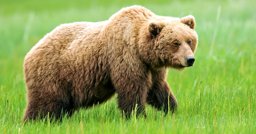

In [6]:
#@ INSPECTING THE IMAGES: 
dest = Path("./images")                      # Initializing Destination for Images. 
if dest.exists():                            # Inspecting Destination. 
    os.remove(dest)
download_url(urls[0], dest)                  # Downloading the Images. 
img = Image.open(dest)                       # Inspecting the Image. 
img.thumbnail((256, 256))                    # Inspecting the Image. 
img

**Note:**
- Awesome! It has worked nicely. I will download all the URLs for each of my search terms using **Fastai**. I will put each on a separate folders. 

In [7]:
#@ GETTING THE DATA: 
bear_types = "grizzly", "black", "teddy"                     # Initializing Types of Bear. 
PATH = Path("/content/bears")                                # Initializing Destination Path. 
if not PATH.exists():                                        # Checking. 
    PATH.mkdir()                                             # Creating. 
    for o in bear_types:
        dest = (PATH/o)                                      # Destination for Each Types. 
        dest.mkdir(exist_ok=True)                            # Initializing Destination if not. 
        urls = search_images_DDG(f"{o} bear")                # Getting the URLs. 
        download_images(dest, urls=urls)                     # Downloading Images. 

In [8]:
#@ INSPECTING THE DATASET: 
fnames = get_image_files(PATH)                               # Getting Image Files. 
fnames[0:2]                                                  # Inspecting. 

(#2) [Path('/content/bears/black/00000124.jpg'),Path('/content/bears/black/00000140.jpg')]

In [9]:
#@ INSPECTING CORRUPTED FILES: 
failed = verify_images(fnames)                               # Verifying Images. 
failed.map(Path.unlink);                                     # Removing Corrupted Images. 
len(failed)                                                  # Inspecting. 

0

### **DATA TO DATALOADERS:**
- **DataLoaders** is defined as a **Fastai** class that stores multiple **DataLoader** objects you pass to it. 

In [10]:
#@ CREATING DATALOADERS: 
bears = DataBlock(blocks=(ImageBlock, CategoryBlock),        # Initializing DataBlock. 
                  get_items=get_image_files,                 # Getting Image Files. 
                  splitter=RandomSplitter(valid_pct=0.2, 
                                          seed=42),          # Splitting Dataset. 
                  get_y=parent_label,                        # Getting Folders name. 
                  item_tfms=Resize(128))                     # Resizing Images. 
dls = bears.dataloaders(PATH)                                # Initializing DataLoaders. 

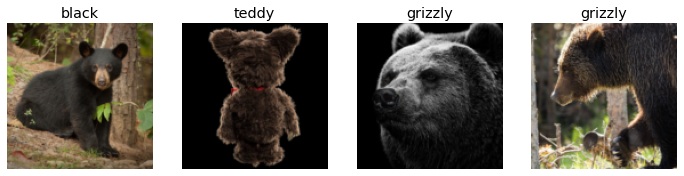

In [11]:
#@ INSPECTING THE DATALOADER: 
dls.valid.show_batch(max_n=4, nrows=1)                       # Inspecting Images. 

**Note:**
- Resize crops the images to fit a square shape of the size requested using
the full width or height. This can result in losing some important details. Therefore I will ask **Fastai** to pad the images or stretch or squish the images. 

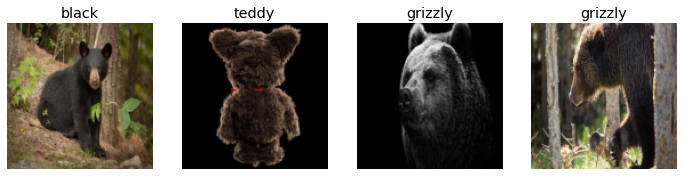

In [12]:
#@ PREPARING THE DATASET: STRETCHING: 
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))     # Stretching the Images. 
dls = bears.dataloaders(PATH)                                     # Initializing the DataLoaders. 
dls.valid.show_batch(max_n=4, nrows=1)                            # Inspecting the Images. 

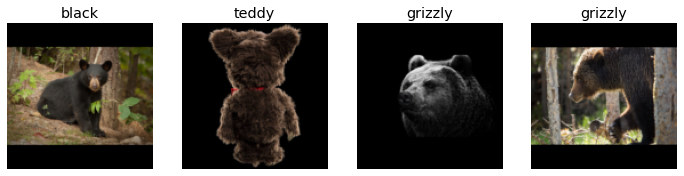

In [13]:
#@ PREPARING THE DATASET: PADDING: 
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, 
                                   pad_mode="zeros"))            # Padding the Images with Zeros. 
dls = bears.dataloaders(PATH)                                    # Initializing DataLoaders. 
dls.valid.show_batch(max_n=4, nrows=1)                           # Inspecting the Images. 

**Note:**
- When the images are squished or stretched, they end up as unrealistic shapes and leading to a model that learns that things look different from how they actually are and results in lower accuracy. Therefore I will randomly select part of the image and
then crop to just that part. On each epoch I will randomly select a different part of each image which means that the model can learn to focus on and recognize different features in images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.


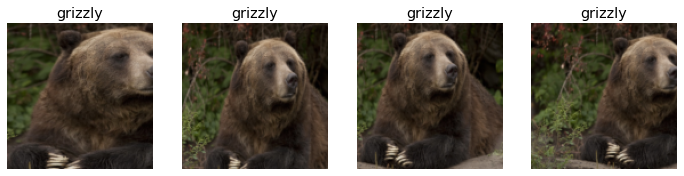

In [14]:
#@ PREPARING THE DATASET: 
bears = bears.new(item_tfms=RandomResizedCrop(128, 
                                              min_scale=0.3))   # Initializing Randomized Crop. 
dls = bears.dataloaders(PATH)                                   # Initializing DataLoaders. 
dls.train.show_batch(max_n=4, nrows=1, unique=True)             # Inspecting same Image. 

### **DATA AUGMENTATION:**
- **Data Augmentation** refers to creating random variations of the input data such that they appear different but do not change the meaning of the data. **RandomResizedCrop** is a specific example of **Data Augmentation**.

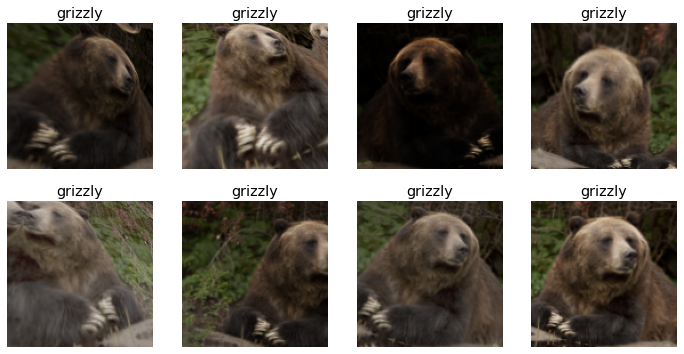

In [15]:
#@ IMPLEMENTATION OF DATA AUGMENTATION: 
bears = bears.new(item_tfms=Resize(128),                        # Initializing Resize. 
                  batch_tfms=aug_transforms(mult=2))            # Initializing Augmentation Function. 
dls = bears.dataloaders(PATH)                                   # Initializing DataLoaders. 
dls.train.show_batch(max_n=8, nrows=2, unique=True)             # Inspecting same Image. 

### **TRAINING THE MODEL:**

In [16]:
#@ INITIALIZING FINAL DATALOADERS: 
bears = bears.new(item_tfms=RandomResizedCrop(224, 
                                              min_scale=0.5),   # Initializing Randomized Crop.
                  batch_tfms=aug_transforms())                  # Initializing Data Augmentation. 
dls = bears.dataloaders(PATH)                                   # Initializing Data Loaders. 

In [17]:
#@ TRAINING THE MODEL: 
learn = cnn_learner(dls, resnet18,                        # Using Pretrained RESNET Model. 
                    metrics=error_rate)                   # Building Convolutional Model. 
learn.fine_tune(4)                                        # Training the Model.

epoch,train_loss,valid_loss,error_rate,time
0,1.287627,0.282019,0.138298,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.252263,0.073115,0.031915,00:28
1,0.159619,0.044837,0.010638,00:27
2,0.108878,0.046571,0.010638,00:27
3,0.082742,0.040768,0.010638,00:28


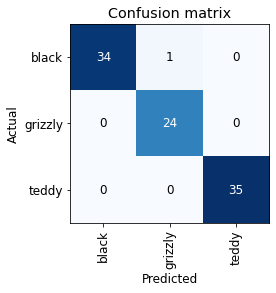

In [18]:
#@ INSPECTING THE MODEL: 
interp = ClassificationInterpretation.from_learner(learn)  # Initializing Interpretation. 
interp.plot_confusion_matrix()                             # Creating Confusion Matrix. 

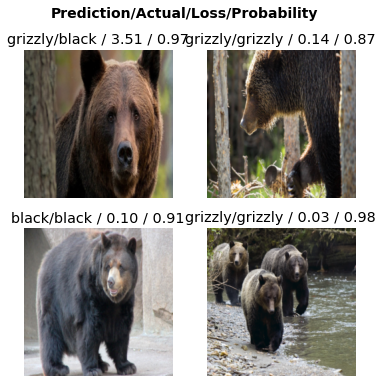

In [19]:
#@ INSPECTING INCORRECT PREDICTIONS: 
interp.plot_top_losses(4, nrows=2)                  # Inspecting Top Losses. 

In [20]:
#@ INITIALIZING DATA CLEANING:
cleaner = ImageClassifierCleaner(learn)            # Initializing Image Cleaner. 
cleaner 

In [21]:
#@ CLEANING THE DATA: 
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()                       # Deleting the Images. 

In [22]:
#@ CLEANING THE DATA: 
for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), PATH/cat)    # Moving the Images. 

### **MODEL FOR INFERENCE:**

In [23]:
#@ SAVING THE MODEL: 
learn.export()                                      # Saving the Model. 

In [24]:
#@ CHECKING THE MODEL: 
path = Path()                                       # Initialization. 
path.ls(file_exts=".pkl")                           # Inspecting. 

(#1) [Path('export.pkl')]

**Note:**
- When the model is used for getting predictions instead of training, it is called **Inference**. To create a **Inference Learner**, I will use exported file. 

In [25]:
#@ INITIALIZING INFERENCE LEARNER MODEL: 
learn_inf = load_learner(path/"export.pkl")         # Initializing Model. 
learn_inf.predict("/content/B.jpg")                 # Getting Predictions. 

('black', tensor(0), tensor([0.7370, 0.0977, 0.1653]))

**IMPLEMENTATION OF WIDGETS:**

In [26]:
#@ UPLOADING THE DATA:
upload = widgets.FileUpload()                        # Initialization. 
upload

FileUpload(value={}, description='Upload')

In [27]:
#@ GETTING THE IMAGE: 
img = PILImage.create(upload.data[-1])               # Initialization. 
output = widgets.Output()                            # Initializing Output. 
output.clear_output()
with output: 
    display(img.to_thumb(128, 128))
output                                               # Inspecting Image. 

Output()

In [28]:
#@ GETTING THE PREDICTIONS: 
pred, pred_index, probs = learn_inf.predict(img)                # Getting Predictions. 
lbl_pred = widgets.Label()                                      # Initializing Label. 
lbl_pred.value = f"Prediction: {pred}; Probability: "\
                 f"Probability: {probs[pred_index]:.04f}"
lbl_pred

Label(value='Prediction: black; Probability: Probability: 0.7370')

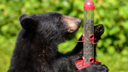

In [29]:
#@ GETTING THE CLASSIFICATION: 
run = widgets.Button(description="Classify")                    # Initialization. 
run

In [31]:
#@ INITIALIZING DEPENDENCIES:
def on_click_classify(change):                                 # Initializing Function. 
    img = PILImage.create(upload.data[-1])                     # Getting the Image. 
    output.clear_output()                                      # Initializing Output. 
    with output: display(img.to_thumb(128, 128))               # Getting Output. 
    pred, pred_index, probs = learn_inf.predict(img)           # Getting Predictions. 
    lbl_pred.value = f"Prediction: {pred}; Probability: "\
                     f"Probability: {probs[pred_index]:.04f}"  # Getting Classification. 

#@ IMPLEMENTATION: 
run.on_click(on_click_classify)                                # Implementation of Function. 

In [32]:
#@ GUI IMPLEMENTATION: 
VBox([widgets.Label("Select your bear!"), 
      upload, run, output, lbl_pred])                          # Final GUI. 